In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [61]:
class Model:
    def __init__(self,df,store):
        
        df = df[df['Store']==store]
        
        state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
        school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values
        state = pd.DataFrame({'holiday': 'state_holiday',
                              'ds': pd.to_datetime(state_dates)})
        school = pd.DataFrame({'holiday': 'school_holiday',
                              'ds': pd.to_datetime(school_dates)})
        holidays = pd.concat((state, school)) 
        self.holidays = holidays

        sales = df.loc[:, ['Date', 'Sales']]
        sales = sales.sort_index(ascending = False)
        sales['Date'] = pd.DatetimeIndex(sales['Date'])
        sales = sales.rename(columns = {'Date': 'ds',
                                        'Sales': 'y'})
        self.sales = sales
        self.model = Prophet(interval_width = 0.8, 
                           holidays = holidays)
        self.model.fit(sales)

    def predict(self,days,file_location):
        future_dates = self.model.make_future_dataframe(periods = days)
        forecast = self.model.predict(future_dates[-days:])
        output = forecast[["ds","yhat","yhat_lower","yhat_upper"]]
        num = output._get_numeric_data()
        num[num<0] = 0
        
        tail = self.sales
        plt.figure(figsize=(20,10))
        plt.plot(tail["ds"],tail["y"],label="Historical Data")
        plt.plot(output["ds"],output["yhat"],label="Predicted Data")
        plt.fill_between(output["ds"],output["yhat_lower"],output["yhat_upper"],color="#C9C4C4",label="Prediction Interval")
        plt.xlabel("Date")
        plt.ylabel("Sales Quantity")
        plt.title("Sales Prediction")
        plt.legend()
        plt.savefig(file_location+"/fig1.png")
        return output
    
    def evaluate_for_all(self,df,store):
        days = 6*7
        
        df = df[df['Store']==store]
        sales = df.loc[:, ['Date', 'Sales']]
        sales = sales.sort_index(ascending = False)
        sales['Date'] = pd.DatetimeIndex(sales['Date'])
        sales = sales.rename(columns = {'Date': 'ds',
                                        'Sales': 'y'})
        
        self.model = Prophet(changepoint_prior_scale=0.5,yearly_seasonality=20,weekly_seasonality=20,interval_width = 0.5,daily_seasonality=False)
        self.model.add_seasonality(name='two_weeks', period=14, fourier_order=5)
        self.model.fit(sales)
        future_dates = self.model.make_future_dataframe(periods = days)
        forecast = self.model.predict(future_dates[-2*days:-days])
        output = forecast[["ds","yhat_lower","yhat_upper"]]
        tail = self.sales.tail(days)
        output[output["yhat_lower"]<0]["yhat_lower"] = 0
        
        plt.figure(figsize=(20,3))
        plt.plot(tail["ds"],tail["y"],color="black",label="Actual Data")
        plt.fill_between(output["ds"],output["yhat_lower"],output["yhat_upper"],color="#C9C4C4",label="Predicted Interval")
        plt.xlabel("Date")
        plt.ylabel("Sales Quantity")
        plt.title("Sales Prediction")
        plt.legend()
        plt.show()
        correct = 0
        wrong = 0
        t = []
        
        for i in tail.iterrows():
            date = i[1].get("ds")
            value = i[1].get("y")
            try:
                pred = output[output["ds"]==date].values[0]
            except:
                continue
            
            upper_limit = pred[2]
            lower_limit = pred[1]
            
            if value<=upper_limit and value>=lower_limit:
                correct +=1
            else:
                wrong+=1
            
            t.append(upper_limit-lower_limit)
        print(correct,wrong)
        return (float(correct)/(correct+wrong),sum(t)/len(t))
    
    def evaluate(self,df,store):
        days = 6*7
        
        df = df[df['Store']==store]
        sales = df.loc[:, ['Date', 'Sales']]
        sales = sales.sort_index(ascending = False)
        sales['Date'] = pd.DatetimeIndex(sales['Date'])
        sales = sales.rename(columns = {'Date': 'ds',
                                        'Sales': 'y'})
        
        self.model = Prophet(changepoint_prior_scale=0.5,yearly_seasonality=20,weekly_seasonality=20,interval_width = 0.5,daily_seasonality=False)
        self.model.add_seasonality(name='two_weeks', period=14, fourier_order=5)
        self.model.fit(sales)
        future_dates = self.model.make_future_dataframe(periods = days)
        forecast = self.model.predict(future_dates[-2*days:-days])
        output = forecast[["ds","yhat_lower","yhat_upper"]]
        tail = self.sales
        output[output["yhat_lower"]<0]["yhat_lower"] = 0
        
        plt.figure(figsize=(20,3))
        plt.plot(tail["ds"],tail["y"],color="black",label="Actual Data")
        plt.fill_between(output["ds"],output["yhat_lower"],output["yhat_upper"],color="#C9C4C4",label="Predicted Interval")
        plt.xlabel("Date")
        plt.ylabel("Sales Quantity")
        plt.title("Sales Prediction")
        plt.legend()
        plt.show()
        correct = 0
        wrong = 0
        t = []
        
        for i in tail.iterrows():
            date = i[1].get("ds")
            value = i[1].get("y")
            try:
                pred = output[output["ds"]==date].values[0]
            except:
                continue
            
            upper_limit = pred[2]
            lower_limit = pred[1]
            
            if value<=upper_limit and value>=lower_limit:
                correct +=1
            else:
                wrong+=1
            
            t.append(upper_limit-lower_limit)
        print(correct,wrong)
        return (float(correct)/(correct+wrong),sum(t)/len(t))
        
            

In [56]:
df = pd.read_csv('train.csv')

In [57]:
df.shape

(1017209, 9)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


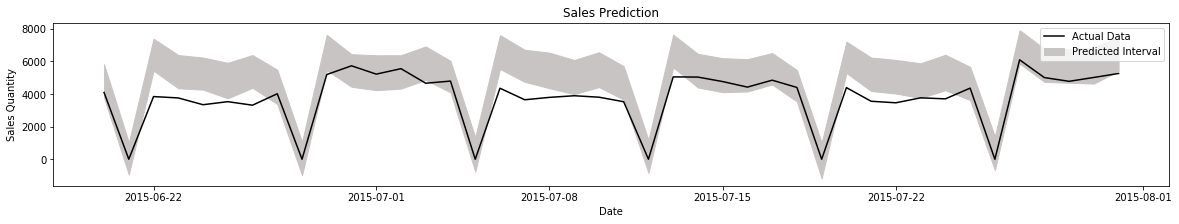

23 19


(0.5476190476190477, 2059.1417564819735)

In [62]:
m = Model(df,1)
m.evaluate_for_all(df,23)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store  1


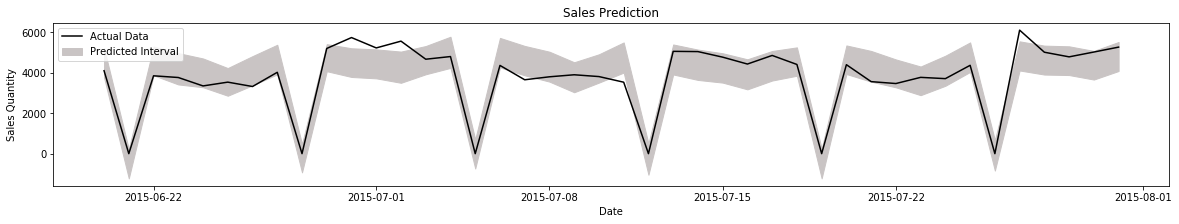

34 8
accuracy =  0.8095238095238095  range =  1450.5602143893552
Store  2


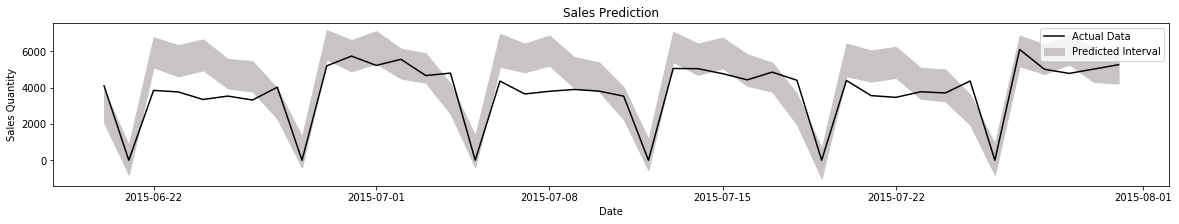

20 22
accuracy =  0.47619047619047616  range =  1692.1458424796535
Store  3


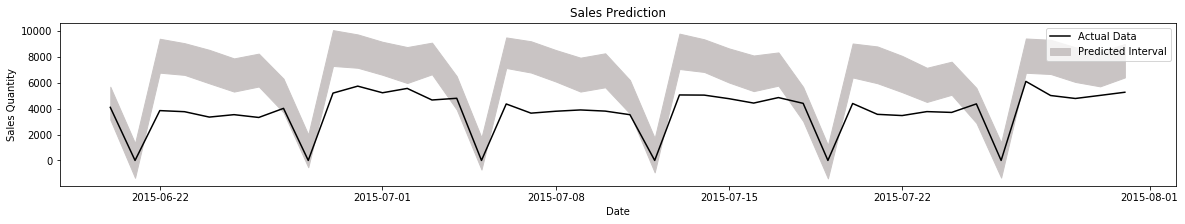

11 31
accuracy =  0.2619047619047619  range =  2604.3324292565817
Store  4


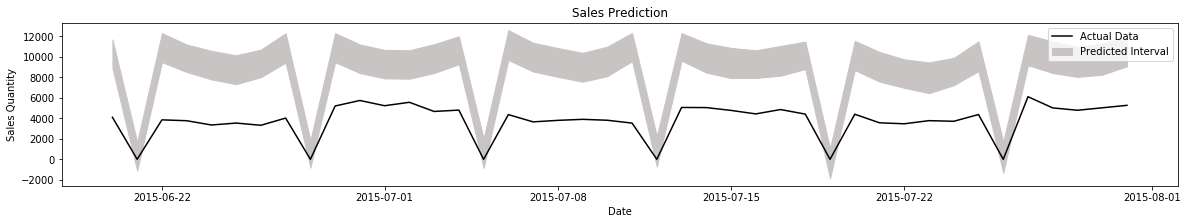

6 36
accuracy =  0.14285714285714285  range =  2840.0481054580473
Store  5


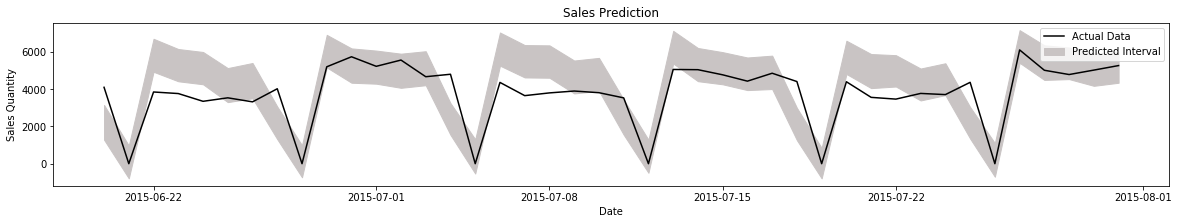

24 18
accuracy =  0.5714285714285714  range =  1765.445989378072
Store  6


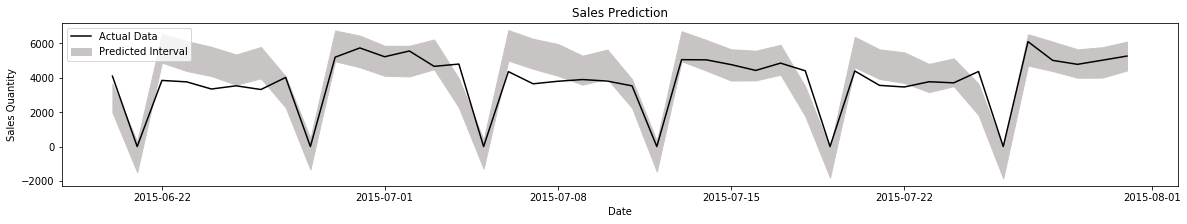

24 18
accuracy =  0.5714285714285714  range =  1742.8212432099422
Store  7


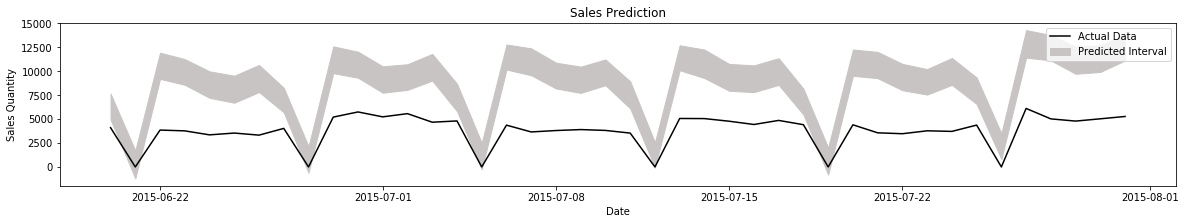

5 37
accuracy =  0.11904761904761904  range =  2749.5210148425062
Store  8


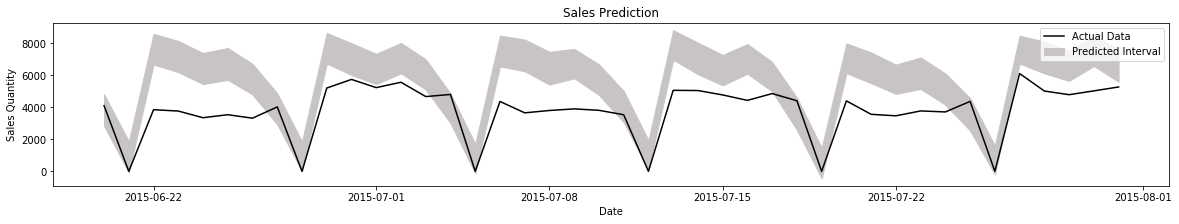

10 32
accuracy =  0.23809523809523808  range =  1915.8593369288199
Store  9


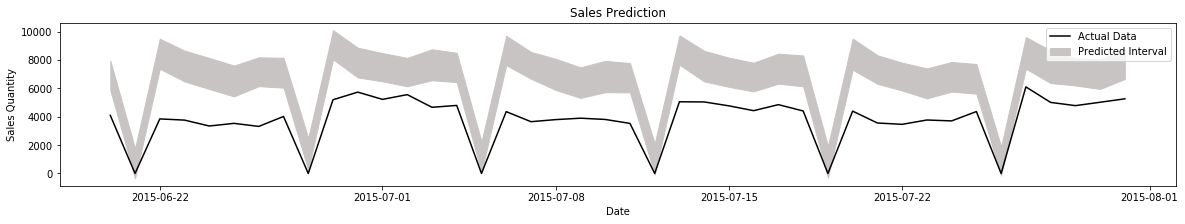

4 38
accuracy =  0.09523809523809523  range =  2107.338743649792
Store  10


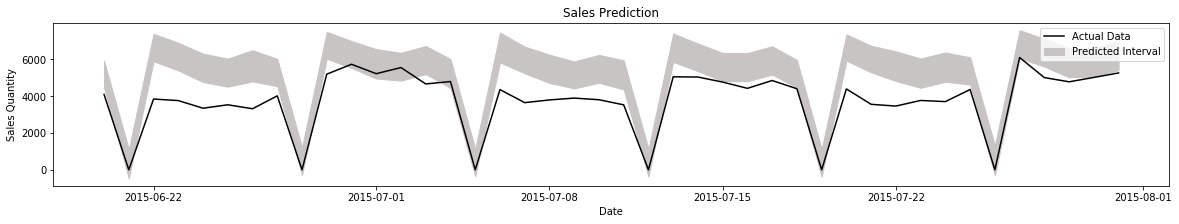

11 31
accuracy =  0.2619047619047619  range =  1530.465211614282
Store  11


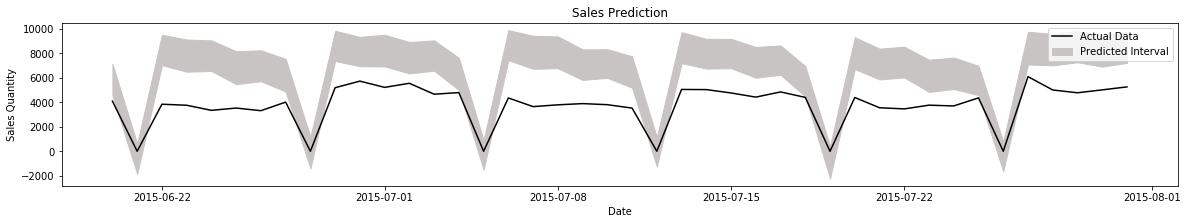

6 36
accuracy =  0.14285714285714285  range =  2530.0909290190416
Store  12


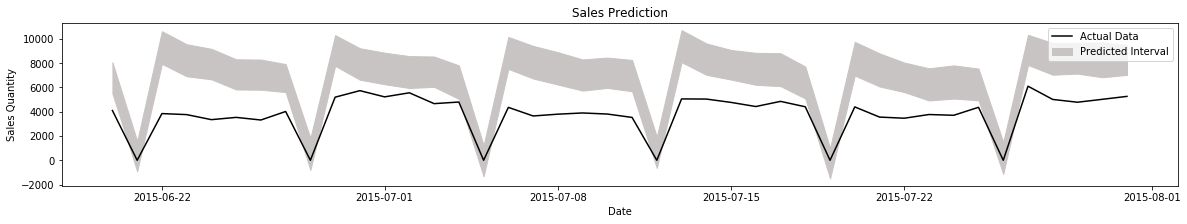

6 36
accuracy =  0.14285714285714285  range =  2593.6562527354413
Store  13


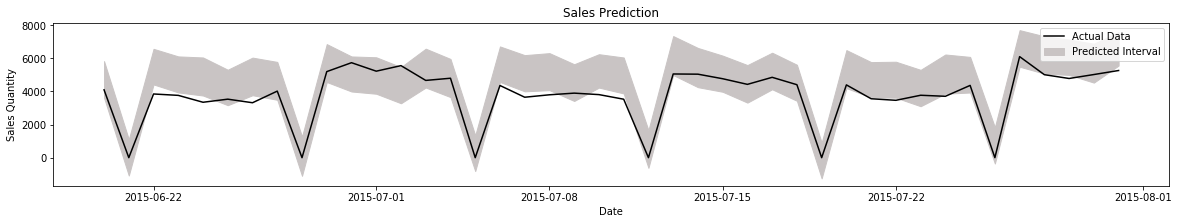

26 16
accuracy =  0.6190476190476191  range =  2217.779123516341
Store  14


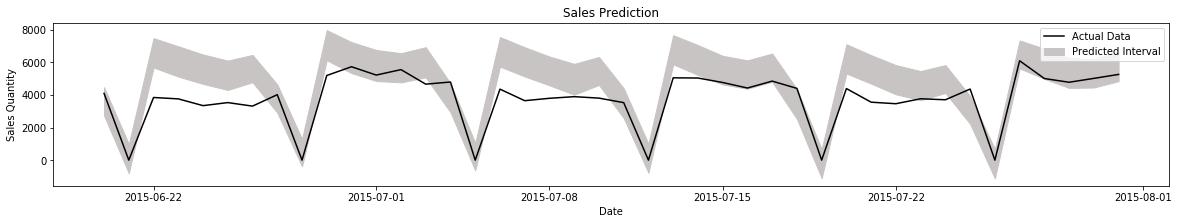

21 21
accuracy =  0.5  range =  1786.78798427869
Store  15


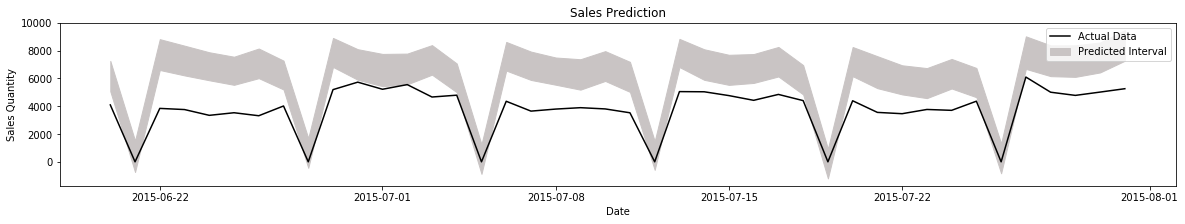

6 36
accuracy =  0.14285714285714285  range =  2144.0145297503605
Store  16


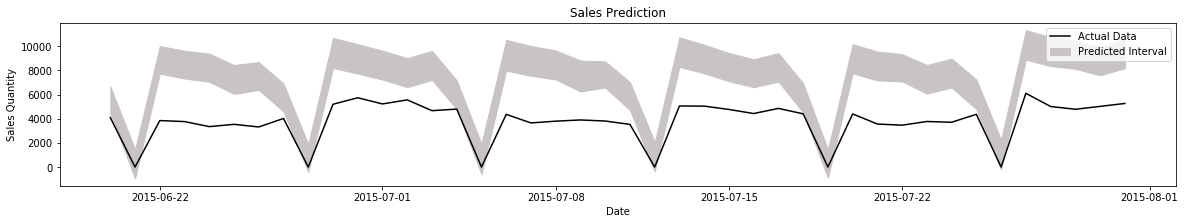

7 35
accuracy =  0.16666666666666666  range =  2384.8391246980777
Store  17


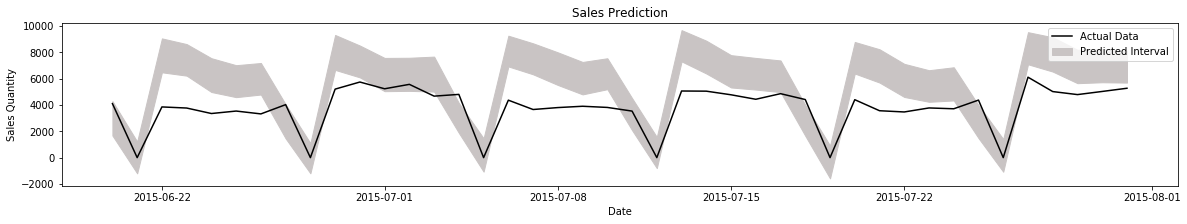

11 31
accuracy =  0.2619047619047619  range =  2460.747239645046
Store  18


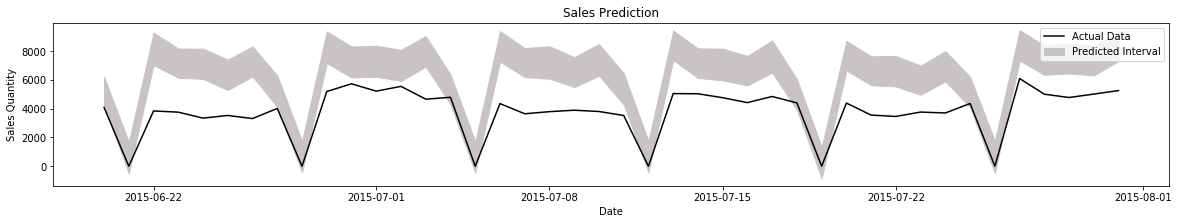

9 33
accuracy =  0.21428571428571427  range =  2120.057665964144
Store  19


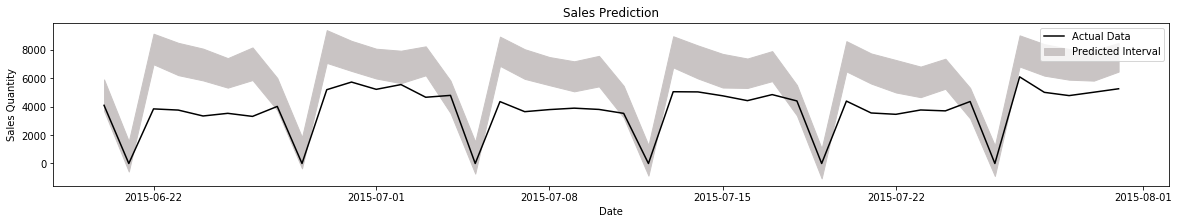

12 30
accuracy =  0.2857142857142857  range =  2171.1126695146936
Store  20


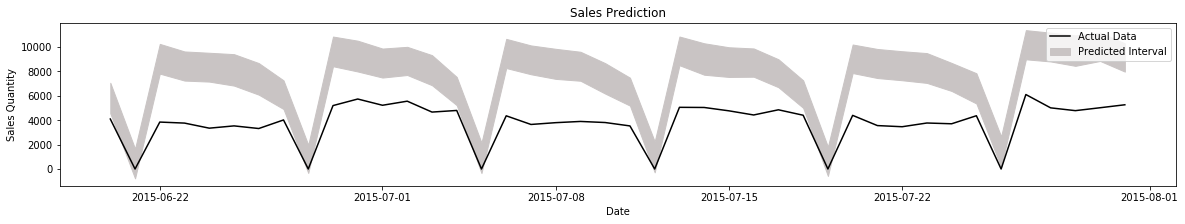

5 37
accuracy =  0.11904761904761904  range =  2407.1671121066297
Store  21


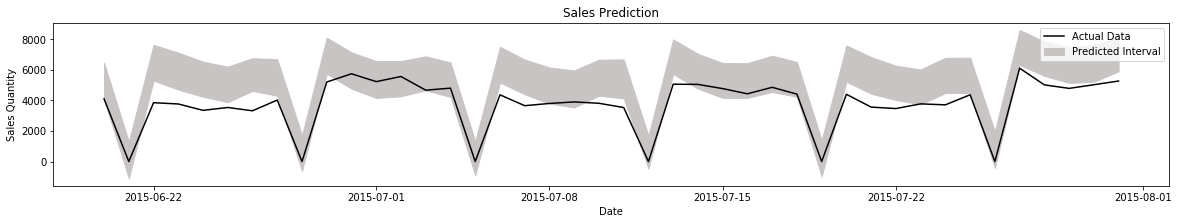

20 22
accuracy =  0.47619047619047616  range =  2320.271111464534
Store  22


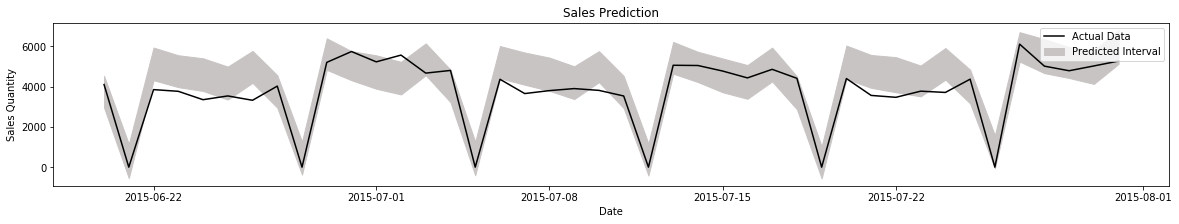

31 11
accuracy =  0.7380952380952381  range =  1610.1654028926
Store  23


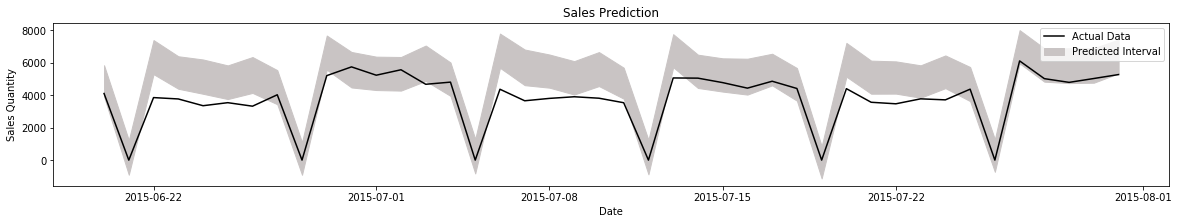

22 20
accuracy =  0.5238095238095238  range =  2067.5354603277674
Store  24


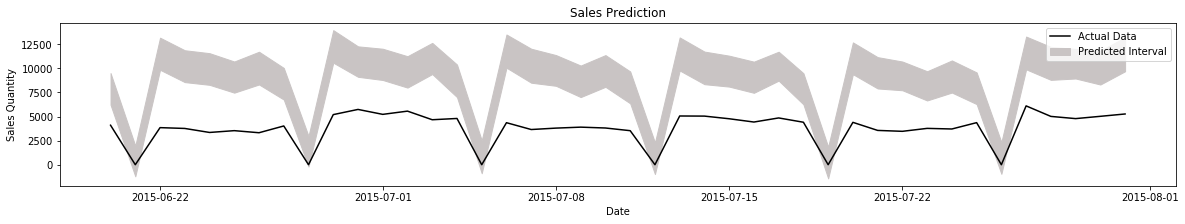

6 36
accuracy =  0.14285714285714285  range =  3284.437978023223
Store  25


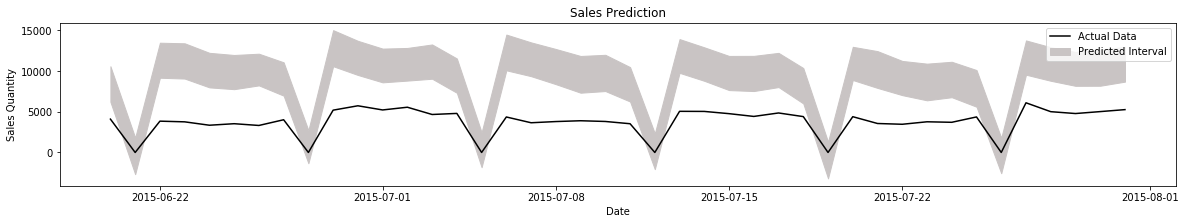

6 36
accuracy =  0.14285714285714285  range =  4273.784122223943
Store  26


KeyboardInterrupt: 

In [58]:
m = Model(df,1)
for i in range(1115):
    print("Store ",i+1)
    (a,r) = m.evaluate_for_all(df,i+1)
    print("accuracy = ",a," range = ",r)

In [37]:
m = Model(df,555)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


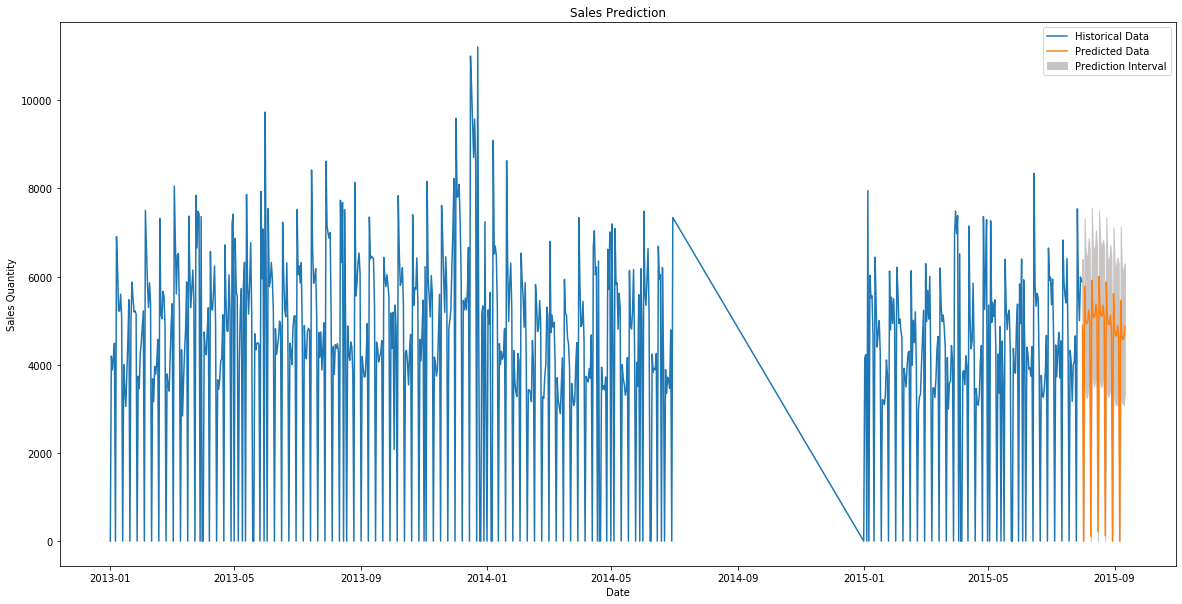

In [38]:
x = m.predict(6*7,".")

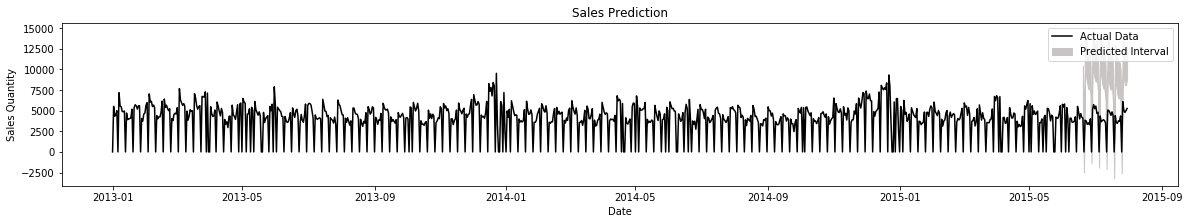

6 36


(0.14285714285714285, 4289.078274578295)

In [63]:
m.evaluate(df,25)

In [16]:
output = x[["ds","yhat","yhat_lower","yhat_upper"]]

In [43]:
output

,ds,yhat,yhat_lower,yhat_upper
0,2015-08-01,5379.379910,3804.905620,6908.596220
1,2015-08-02,5871.314076,4235.920536,7565.403636
2,2015-08-03,7081.961090,5504.715404,8688.261333
3,2015-08-04,6274.142443,4749.111668,7848.660202
4,2015-08-05,5813.719474,4365.677435,7516.353082
5,2015-08-06,5813.500556,4267.796189,7385.548686
6,2015-08-07,6041.559966,4438.315203,7776.493655
7,2015-08-08,5207.777147,3576.591244,6727.025143
8,2015-08-09,5691.110552,4039.079325,7316.224183
9,2015-08-10,6895.821674,5257.615924,8486.639119


In [11]:
x.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
821,2015-09-07,5809.615341,4738.098166,7656.180793,5809.611542,5809.618212,463.860023,463.860023,463.860023,0.0,...,990.726401,990.726401,990.726401,-526.866379,-526.866379,-526.866379,0.0,0.0,0.0,6273.475364
822,2015-09-08,5810.387738,3934.037535,7143.801097,5810.383813,5810.390703,-305.060228,-305.060228,-305.060228,0.0,...,196.834008,196.834008,196.834008,-501.894236,-501.894236,-501.894236,0.0,0.0,0.0,5505.327509
823,2015-09-09,5811.160135,3446.975772,6714.530904,5811.156084,5811.163256,-704.125997,-704.125997,-704.125997,0.0,...,-230.978892,-230.978892,-230.978892,-473.147105,-473.147105,-473.147105,0.0,0.0,0.0,5107.034137
824,2015-09-10,5811.932532,3551.833019,6897.427488,5811.928355,5811.935782,-662.214708,-662.214708,-662.214708,0.0,...,-221.432551,-221.432551,-221.432551,-440.782157,-440.782157,-440.782157,0.0,0.0,0.0,5149.717824
825,2015-09-11,5812.704929,3797.666382,7013.489571,5812.700626,5812.708347,-376.867708,-376.867708,-376.867708,0.0,...,28.175146,28.175146,28.175146,-405.042854,-405.042854,-405.042854,0.0,0.0,0.0,5435.837220
